In [72]:
import numpy as np
import yfinance  as yf
import pandas as pd
import matplotlib.pyplot as plt
import pypfopt
import seaborn as sns
import plotly.express as px

#tickers
tickers = ['TAL', 'ANF', 'JPM', 'DLR', 'MSFT', 'NVO', 'LRN', 'WELL', 'META', 'SEPL.L', 'SQ', 'UBER']

In [73]:
#portfolio data for past 5 yrs 
portfolio = yf.download(tickers, start = "2019-11-23", end = "2024-11-23")['Adj Close']
portfolio.ffill(inplace=True)
portfolio.head()

[*********************100%***********************]  12 of 12 completed


Ticker,ANF,DLR,JPM,LRN,META,MSFT,NVO,SEPL.L,SQ,TAL,UBER,WELL
Date,,,,,,,,,,,,
2019-11-25,15.904396,99.005722,113.796432,20.150000,199.190247,144.649292,26.328163,62.099529,68.250000,43.889999,29.110001,70.680405
2019-11-26,15.495342,100.947334,113.952171,19.459999,198.372711,145.414474,26.328163,61.459305,68.940002,43.930000,29.530001,71.844376
2019-11-27,16.303709,101.432732,114.289726,19.850000,201.393616,145.691879,26.379652,61.459305,69.650002,45.200001,29.490000,72.914902
2019-11-28,16.303709,101.432732,114.289726,19.850000,201.393616,145.691879,26.379652,60.947163,69.650002,45.200001,29.490000,72.914902
2019-11-29,15.553779,101.223518,114.030083,19.650000,201.034714,144.792770,26.281363,60.435005,69.120003,44.259998,29.600000,71.852875


In [74]:
#SP500 benchmark for past 5 yrs
market_prices = yf.download("SPY", start = "2019-11-23", end = "2024-11-23")['Adj Close']
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Ticker,SPY
Date,
2019-11-25,290.084564
2019-11-26,290.741852
2019-11-27,292.037781
2019-11-29,290.954742
2019-12-02,288.483246


In [75]:
#market caps
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'TAL': 6248284160,
 'ANF': 7540035072,
 'JPM': 703244009472,
 'DLR': 66026000384,
 'MSFT': 3148374343680,
 'NVO': 464527687680,
 'LRN': 4666147328,
 'WELL': 86740697088,
 'META': 1436937093120,
 'SEPL.L': 1546022144,
 'SQ': 55027097600,
 'UBER': 151526883328}

In [76]:
#using ledoit-wolf covariance shrinkage for implied market returns
#S is covariance
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

Ticker
SPY    3.335509
dtype: float64

<Axes: xlabel='Ticker', ylabel='Ticker'>

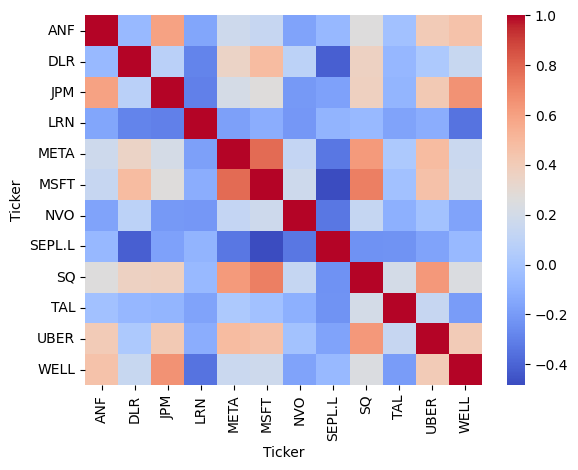

In [77]:
#covariance correlation heatmap
sns.heatmap(S.corr(), cmap='coolwarm')

In [78]:
#market priors
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
ANF      NaN
DLR      NaN
JPM      NaN
LRN      NaN
META     NaN
MSFT     NaN
NVO      NaN
SEPL.L   NaN
SPY      NaN
SQ       NaN
TAL      NaN
UBER     NaN
WELL     NaN
dtype: float64

In [79]:
#views
viewdict = {
    'ANF':
}

SyntaxError: expression expected after dictionary key and ':' (1253476498.py, line 3)